# Get data

In [173]:
import torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [174]:
names = open("names.txt").read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

# Create dataset

In [175]:
context = 3

In [176]:
import pdb

ds = []
for name in names:
    n = '.'*context + name + '.'
    tuples = list(zip(*list(n[i:] for i in range(context + 1))))
    ds.extend(list(map(lambda tup: (tup[0:context], tup[context]), tuples)))

ds[:15]

[(('.', '.', '.'), 'e'),
 (('.', '.', 'e'), 'm'),
 (('.', 'e', 'm'), 'm'),
 (('e', 'm', 'm'), 'a'),
 (('m', 'm', 'a'), '.'),
 (('.', '.', '.'), 'o'),
 (('.', '.', 'o'), 'l'),
 (('.', 'o', 'l'), 'i'),
 (('o', 'l', 'i'), 'v'),
 (('l', 'i', 'v'), 'i'),
 (('i', 'v', 'i'), 'a'),
 (('v', 'i', 'a'), '.'),
 (('.', '.', '.'), 'a'),
 (('.', '.', 'a'), 'v'),
 (('.', 'a', 'v'), 'a')]

# Vocab

In [177]:
vocab = sorted(set('.'.join(names)))
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [178]:
ctoi = {c: i for i, c in enumerate(vocab)}
itoc = {i: c for c, i in ctoi.items() }

# Embedding

In [179]:
emb_dims = 10
E = torch.randn(len(vocab), emb_dims)
E.shape

torch.Size([27, 10])

In [180]:
ids = torch.zeros(len(ds), context + 1, dtype=torch.int)
for i, (x, y) in enumerate(ds):
    ids[i, 0:context] = torch.tensor(list(map(lambda c: ctoi[c],x)))
    ids[i, context] = ctoi[y]

ids[:10]

tensor([[ 0,  0,  0,  5],
        [ 0,  0,  5, 13],
        [ 0,  5, 13, 13],
        [ 5, 13, 13,  1],
        [13, 13,  1,  0],
        [ 0,  0,  0, 15],
        [ 0,  0, 15, 12],
        [ 0, 15, 12,  9],
        [15, 12,  9, 22],
        [12,  9, 22,  9]], dtype=torch.int32)

# Initialization

In [353]:
nh = 200
Wh = torch.randn(context*emb_dims, nh) * (5/3 / (context*emb_dims)**0.2)
# Bh = torch.randn(nh) * 0.01

no = len(vocab)
Wo = torch.randn(nh, no) * 0.1 
Bo = torch.zeros(no)

bngain = torch.ones(nh)
bnbias = torch.zeros(nh)

bnmean_running = torch.zeros(nh)
bnstd_running = torch.ones(nh)

params = [E, Wh, Wo, Bo, bngain, bnbias]
for  param in params: param.requires_grad_()

In [354]:
import torch.nn.functional as F

In [355]:
ods = F.one_hot(ids.long(), 27)
ods.shape

torch.Size([228146, 4, 27])

In [356]:
ntr = int(len(ods) * 0.8)
nval = int(len(ods) * 0.9)
idx = torch.randint(0, len(ods), (len(ods),))

tr_ds = ods[idx[:ntr]]
val_ds = ods[idx[ntr:nval]]
test_ds = ods[idx[nval:]]

assert sum(list(map(len, [tr_ds, val_ds, test_ds]))) == len(ods)

# Training

In [357]:
def get_batches(bs, ds):
    b = ds[torch.randint(0, len(ds), size=(bs,))].float()

    xb = b[:, 0:context]
    yb = b[:, context]

    return xb, yb

In [358]:
bnmean = None
bnstd = None

In [365]:
def forward(bs, xb, train=True):
    global bnmean_running, bnstd_running, bnmean, bnstd  # Declare the variables as global
    ae = (xb @ E).view(bs, -1)
    zh = ae @ Wh
    bnmean = zh.mean(0, keepdim=True) if train else bnmean_running
    bnstd = zh.std(0, keepdim=True) if train else bnstd_running
    bnh = bngain * ((zh - bnmean) / bnstd) + bnbias

    if train:
        with torch.no_grad():
            mom = 0.001
            bnmean_running = (1 - mom) * bnmean_running + mom * bnmean
            bnstd_running = (1 - mom) * bnstd_running + mom * bnstd
    ah = bnh.tanh()
    z = ah @ Wo + Bo    
    
    return z

In [359]:
def optimize(lr):
    for param in params:
        param.data -= param.grad * lr
        param.grad = None

In [360]:
tr_losses = []
val_losses = []

In [363]:
bs = 32
itr = 200000
rfq = 1000


for i in range(itr):
    # Train
    xb, yb = get_batches(bs, tr_ds)
    z = forward(bs, xb)
    tr_loss = F.cross_entropy(z, yb)
    tr_loss.backward()
    optimize(0.1)

    
    # Eval
    if i % rfq == 0: 
        val_bs = len(val_ds)
        xb, yb = get_batches(val_bs, val_ds)
        with torch.no_grad(): 
            z = forward(val_bs, xb)
            val_loss = F.cross_entropy(z, yb)

        # Report
        print(f"Tr: {tr_loss:.2f} | Val: {val_loss:.2f}")
        tr_losses.append(tr_loss.item())
        val_losses.append(val_loss.item())

    # break

Tr: 1.85 | Val: 2.23
Tr: 2.56 | Val: 2.22
Tr: 2.18 | Val: 2.22
Tr: 2.79 | Val: 2.22
Tr: 2.07 | Val: 2.20
Tr: 2.46 | Val: 2.22
Tr: 1.95 | Val: 2.22
Tr: 2.09 | Val: 2.22
Tr: 1.96 | Val: 2.21
Tr: 1.93 | Val: 2.21
Tr: 2.25 | Val: 2.20
Tr: 2.07 | Val: 2.22
Tr: 1.88 | Val: 2.20
Tr: 1.89 | Val: 2.21
Tr: 2.08 | Val: 2.21
Tr: 2.21 | Val: 2.21
Tr: 2.73 | Val: 2.21
Tr: 2.09 | Val: 2.20
Tr: 2.06 | Val: 2.21
Tr: 2.25 | Val: 2.21
Tr: 2.24 | Val: 2.20
Tr: 1.76 | Val: 2.19
Tr: 2.13 | Val: 2.20
Tr: 2.00 | Val: 2.21
Tr: 2.48 | Val: 2.20
Tr: 2.31 | Val: 2.21
Tr: 2.41 | Val: 2.20
Tr: 1.97 | Val: 2.20
Tr: 2.26 | Val: 2.20
Tr: 2.52 | Val: 2.20
Tr: 2.04 | Val: 2.19
Tr: 2.12 | Val: 2.19
Tr: 2.15 | Val: 2.19
Tr: 1.90 | Val: 2.19
Tr: 2.32 | Val: 2.20
Tr: 2.26 | Val: 2.18
Tr: 1.90 | Val: 2.18
Tr: 2.57 | Val: 2.19
Tr: 2.33 | Val: 2.17
Tr: 2.11 | Val: 2.19
Tr: 1.84 | Val: 2.18
Tr: 2.26 | Val: 2.18
Tr: 2.49 | Val: 2.18
Tr: 2.19 | Val: 2.20
Tr: 2.24 | Val: 2.19
Tr: 1.99 | Val: 2.18
Tr: 1.93 | Val: 2.18
Tr: 2.23 | Va

# Evals

In [364]:
(bnmean_running - bnmean).abs().mean()

tensor(0.7304, grad_fn=<MeanBackward0>)

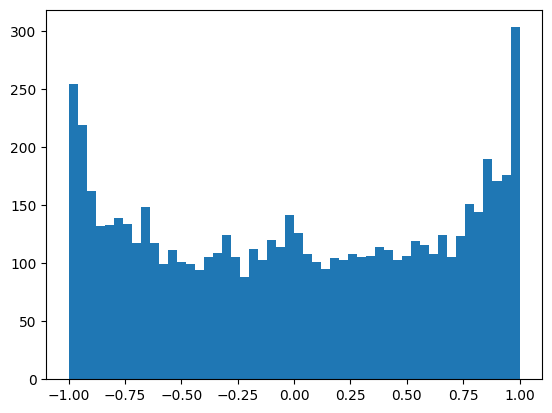

In [313]:
plt.hist(ah.view(-1).tolist(), 50);

In [314]:
zh.shape, zh.mean(0, keepdim=True).shape, zh.std(0, keepdim=True).shape

(torch.Size([32, 200]), torch.Size([1, 200]), torch.Size([1, 200]))

In [315]:
bnh = (zh - zh.mean(0, keepdim=True)) / zh.std(0, keepdim=True)
bnh.shape

torch.Size([32, 200])

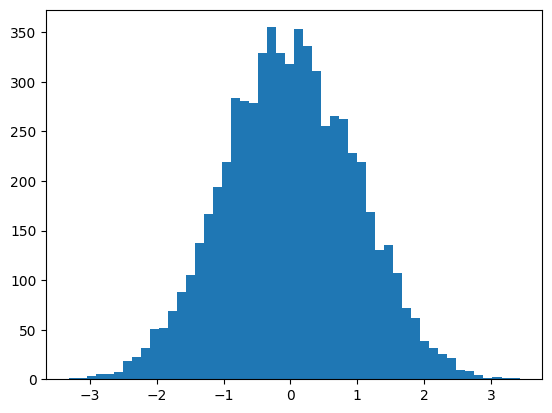

In [316]:
plt.hist(bnh.view(-1).tolist(), 50);

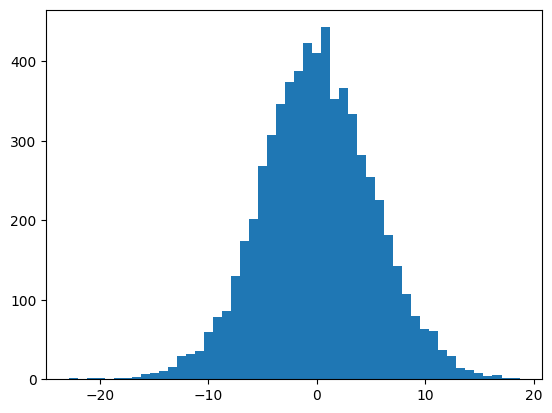

In [317]:
plt.hist(zh.view(-1).tolist(), 50);

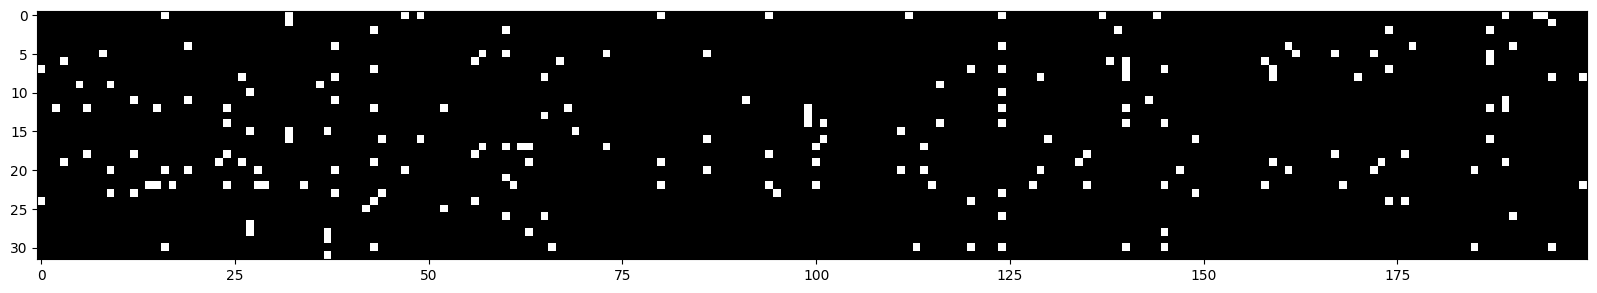

In [318]:
plt.figure(figsize=(20, 10))
plt.imshow(ah.abs() > 0.99, cmap="gray", interpolation="nearest")

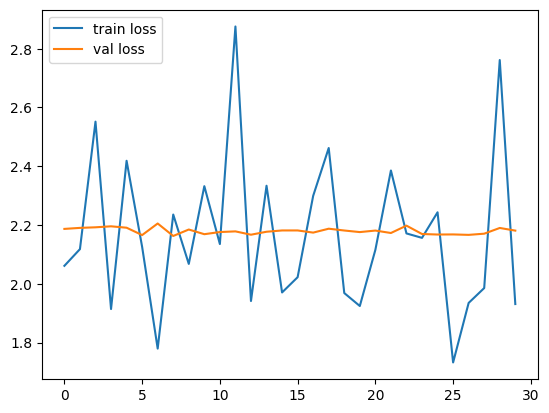

In [265]:
x = np.arange(0, len(tr_losses))
l1, l2 = plt.plot(x, tr_losses, x, val_losses)
l1.set_label("train loss")
l2.set_label("val loss")

plt.legend()


In [393]:
bs = len(test_ds)
x_test, y_test = get_batches(bs, test_ds)

print(f"Test loss is {F.cross_entropy(forward(bs, x_test, False), y_test):.2f}")

Test loss is 2.17


# Name gen

In [195]:
gen = []

for i in range(20):
    res = []
    input = torch.tensor(list(map(int, context*'0')))

    while True:
        z = forward(1, F.one_hot(input, len(vocab)).float())
        predi = torch.multinomial(F.softmax(z, dim=1), 1).squeeze()
        predc = itoc[predi.item()]

        if predc == '.': break

        res.append(predc)
        input = torch.concat([input[1:], predi[None]])

    gen.append(''.join(res))

gen

['osr',
 'certd',
 'kae',
 'laushatro',
 'ken',
 'jak',
 'kalk',
 'ashenna',
 'bri',
 'vakeriesh',
 'joweccaysen',
 'aerenna',
 'ade',
 'wheawc',
 'eamiana',
 'maliavietz',
 'man',
 'malalin',
 'xdri',
 'alyn']

# Pytorchify

In [882]:
class Linear:
    def __init__(self, n_in, n_out, bias=True):
        self.w = torch.randn(n_in, n_out) / (n_in ** 0.5)
        self.b = torch.zeros(n_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.w
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.w] + ([self.b] if self.b is not None else [])
    
class BatchNorm1d:
    def __init__(self, n, momentum=0.001, eps=1e-5):
        self.gain = torch.ones(n)
        self.bias = torch.zeros(n)
        self.r_var = torch.ones(n)
        self.r_mean = torch.zeros(n)
        self.momentum = momentum
        self.eps = eps
        self.training = True

    def __call__(self, x):
        mean = x.mean(0, keepdims=True) if self.training else self.r_mean
        var = x.std(0, keepdims=True) if self.training else self.r_var
        
        self.out = self.gain * (x - mean) / torch.sqrt(var + self.eps) + self.bias

        if self.training:
            with torch.no_grad():
                self.r_var = (1 - self.momentum) * self.r_var + self.momentum * var
                self.r_mean = (1 - self.momentum) * self.r_mean + self.momentum * mean
        
        return self.out

    def parameters(self):
        return [self.gain, self.bias]
        
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    
    def parameters(self):
        return []

## Init

In [883]:
n_emb = 10
n_hidden = 100

C = torch.randn((len(vocab), n_emb))

layers = [
    Linear(context * n_emb, n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden       , n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden       , n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden       , n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden       , n_hidden  ), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden       , len(vocab)),
]

with torch.no_grad():
    for layer in layers[:-1]:
        if isinstance(layer, Linear): layer.w *= 5/3

parameters = [C] + [params for layer in layers for params in layer.parameters()]
for param in parameters: param.requires_grad_()

In [884]:
n1 = int(0.8*len(ids))
n2 = int(0.9*len(ids))

shuffled = ids[torch.randint(0, len(ids), (len(ids),))]

tr = shuffled[0:n1]
val = shuffled[n1:n2]
test = shuffled[n2:]

tr.shape, val.shape, test.shape


(torch.Size([182516, 4]), torch.Size([22815, 4]), torch.Size([22815, 4]))

In [885]:
def getxy(ds):
    return ds[:, :3], F.one_hot(tr[:, -1].long(), len(vocab)).float()

Xtr, Ytr = getxy(tr)
Xval, Yval = getxy(val)
Xtest, Ytest = getxy(test)
Xtr.shape, Ytr.shape

(torch.Size([182516, 3]), torch.Size([182516, 27]))

In [886]:
itr = 50000
bs  = 32
rfq = 1000
lr = 0.05
ud = []

for i in range(itr):
    bi = torch.randint(0, len(Xtr), (bs,))
    xb, yb = Xtr[bi], Ytr[bi]

    # Forward
    x = C[xb].view(bs, -1)
    for layer in layers:
        x = layer(x)

    # Loss
    loss = F.cross_entropy(x, yb)

    # Optim
    for layer in layers: layer.out.retain_grad()
    for p in parameters: p.grad = None
    loss.backward()
    for p in parameters: p.data  -= p.grad * lr

    # Report
    if i % rfq == 0:
        print(f"{i}: {loss:.2f}")
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])


    if i == 10000: break;

0: 3.54
1000: 2.72
2000: 2.73
3000: 2.43
4000: 2.33
5000: 2.37
6000: 2.47
7000: 2.75
8000: 2.22
9000: 2.10
10000: 2.38


## Evals

Text(0.5, 1.0, 'Linear gradient distributions')

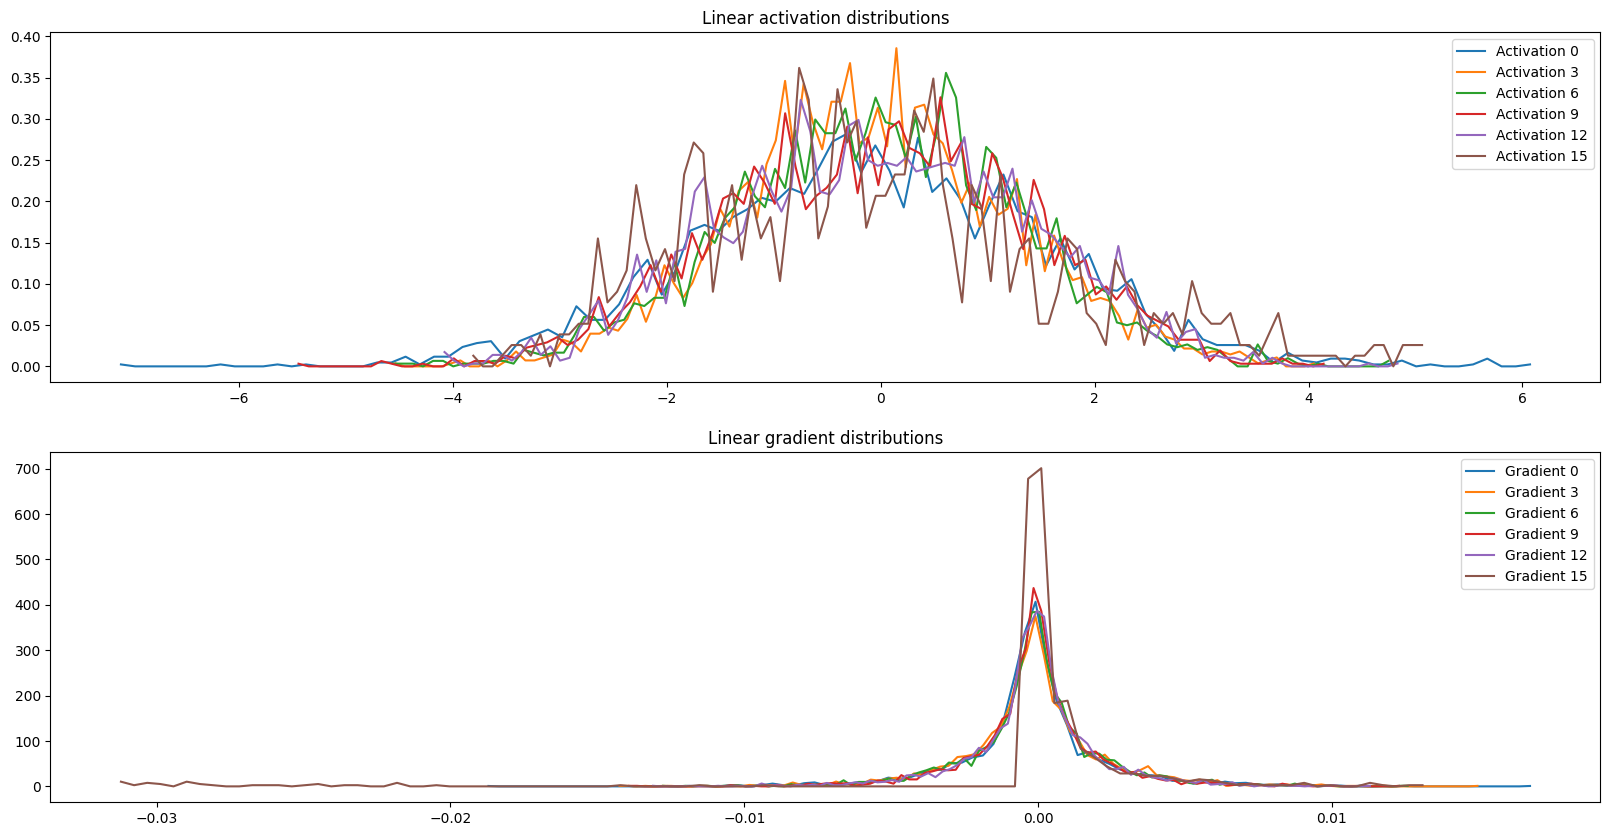

In [887]:
fig, ax = plt.subplots(2, figsize=(20, 10))

# Activation distributions
for i, layer in enumerate(layers):
    if isinstance(layer, Linear):
        hy, hx = torch.histogram(layer.out, density=True)
        ax[0].plot(hx[:-1].detach(), hy.detach(), label=f'Activation {i}')
        hy, hx = torch.histogram(layer.out.grad, density=True)
        ax[1].plot(hx[:-1].detach(), hy.detach(), label=f'Gradient {i}')

ax[0].legend()
ax[1].legend()
ax[0].set_title("Linear activation distributions")
ax[1].set_title("Linear gradient distributions")

In [888]:
for i, layer in enumerate(layers):
    if isinstance(layer, Linear):
        print("%s activations: %2d | mean: %+.2f | std: %e" % (layer.__class__.__name__, i, layer.out.mean(), layer.out.std()))

for i, layer in enumerate(layers):
    if isinstance(layer, Linear):
        print("%s gradients: %2d | mean: %+.2f | std: %e" % (layer.__class__.__name__, i, layer.out.grad.mean(), layer.out.grad.std()))

Linear activations:  0 | mean: -0.02 | std: 1.620081e+00
Linear activations:  3 | mean: -0.01 | std: 1.269587e+00
Linear activations:  6 | mean: +0.01 | std: 1.312713e+00
Linear activations:  9 | mean: -0.00 | std: 1.396377e+00
Linear activations: 12 | mean: +0.00 | std: 1.408310e+00
Linear activations: 15 | mean: +0.00 | std: 1.679040e+00
Linear gradients:  0 | mean: +0.00 | std: 2.445749e-03
Linear gradients:  3 | mean: +0.00 | std: 2.469860e-03
Linear gradients:  6 | mean: +0.00 | std: 2.313160e-03
Linear gradients:  9 | mean: +0.00 | std: 2.171298e-03
Linear gradients: 12 | mean: +0.00 | std: 2.138958e-03
Linear gradients: 15 | mean: -0.00 | std: 5.436649e-03


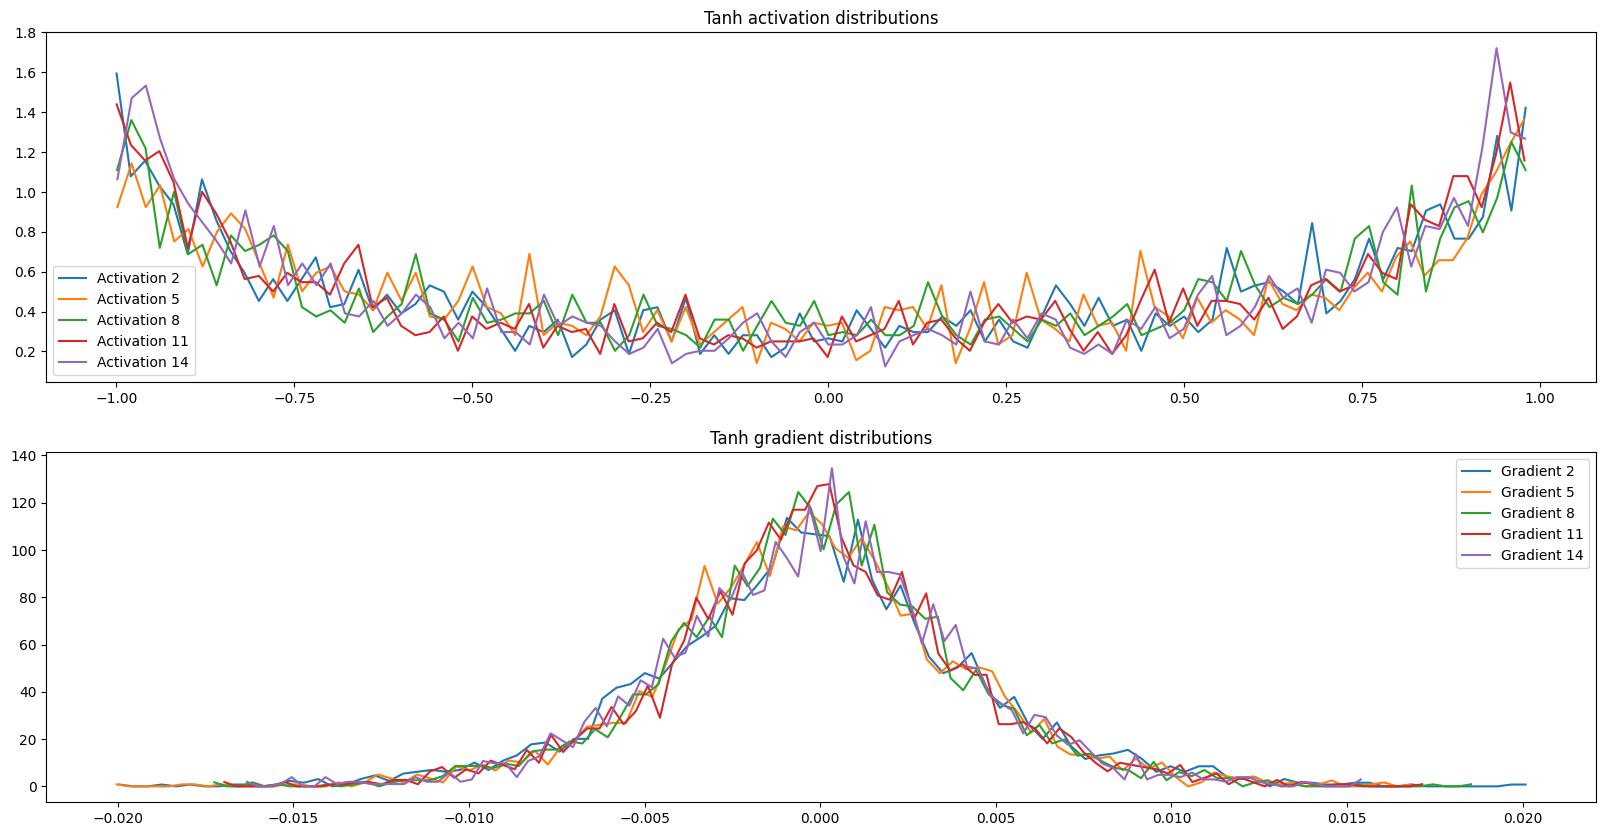

In [889]:
fig, ax = plt.subplots(2, figsize=(20, 10))

# Activation distributions
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        hy, hx = torch.histogram(layer.out, density=True)
        ax[0].plot(hx[:-1].detach(), hy.detach(), label=f'Activation {i}')
        hy, hx = torch.histogram(layer.out.grad, density=True)
        ax[1].plot(hx[:-1].detach(), hy.detach(), label=f'Gradient {i}')

ax[0].legend()
ax[1].legend()
ax[0].set_title("Tanh activation distributions")
ax[1].set_title("Tanh gradient distributions");

In [890]:
for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        print("%s activations: %2d | mean: %+.2f | std: %e | saturation: %.2f%%" % (layer.__class__.__name__, i, layer.out.mean(), layer.out.std(), (layer.out.abs() > 0.97).float().mean() * 100))

for i, layer in enumerate(layers):
    if isinstance(layer, Tanh):
        print("%s gradients: %2d | mean: %+.2f | std: %e" % (layer.__class__.__name__, i, layer.out.grad.mean(), layer.out.grad.std()))

Tanh activations:  2 | mean: +0.00 | std: 6.916499e-01 | saturation: 7.81%
Tanh activations:  5 | mean: -0.02 | std: 6.698858e-01 | saturation: 6.44%
Tanh activations:  8 | mean: +0.01 | std: 6.781182e-01 | saturation: 6.84%
Tanh activations: 11 | mean: +0.01 | std: 7.007415e-01 | saturation: 7.62%
Tanh activations: 14 | mean: -0.00 | std: 7.118121e-01 | saturation: 6.47%
Tanh gradients:  2 | mean: -0.00 | std: 4.599944e-03
Tanh gradients:  5 | mean: +0.00 | std: 4.216431e-03
Tanh gradients:  8 | mean: +0.00 | std: 4.038340e-03
Tanh gradients: 11 | mean: -0.00 | std: 4.093174e-03
Tanh gradients: 14 | mean: +0.00 | std: 4.147119e-03


weight   (27, 10) | mean -0.000000 | std 1.541133e-02 | grad:data ratio 1.586281e-02
weight  (30, 100) | mean +0.000103 | std 1.308513e-02 | grad:data ratio 4.151874e-02
weight (100, 100) | mean -0.000166 | std 1.012074e-02 | grad:data ratio 5.864055e-02
weight (100, 100) | mean -0.000068 | std 9.658418e-03 | grad:data ratio 5.606417e-02
weight (100, 100) | mean -0.000017 | std 9.004679e-03 | grad:data ratio 5.170409e-02
weight (100, 100) | mean +0.000172 | std 8.878713e-03 | grad:data ratio 5.169248e-02
weight  (100, 27) | mean +0.000000 | std 2.150721e-02 | grad:data ratio 1.573244e-01


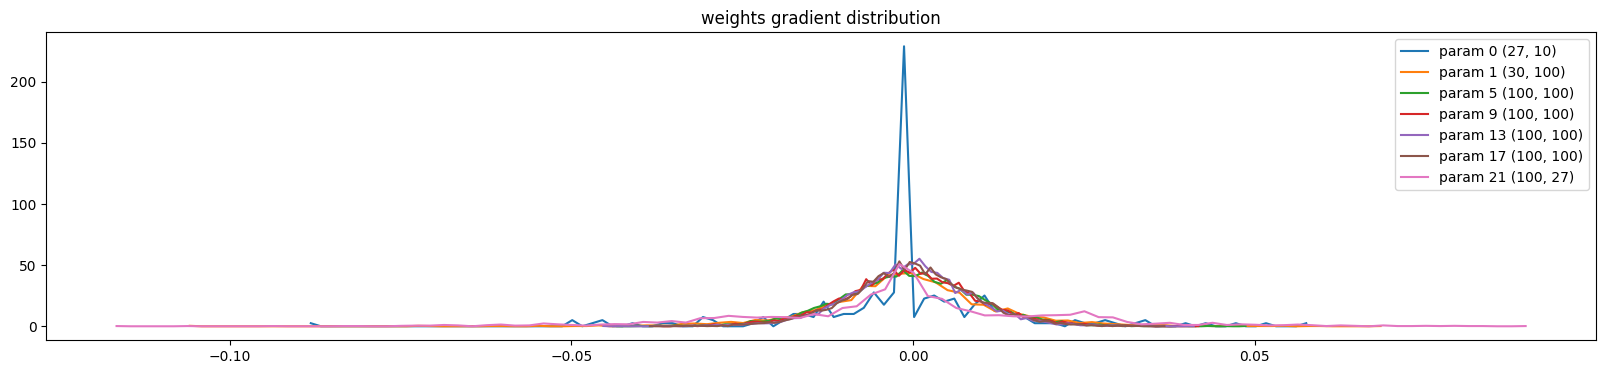

In [891]:
plt.figure(figsize=(20, 4))

for i, p in enumerate(parameters):
    if  p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), p.grad.mean(), p.grad.std(), p.grad.std() / p.std()))
        hy, hx = torch.histogram(p.grad, density=True)
        plt.plot(hx[:-1], hy, label=f"param {i} {tuple(p.shape)}")

plt.legend();
plt.title("weights gradient distribution");


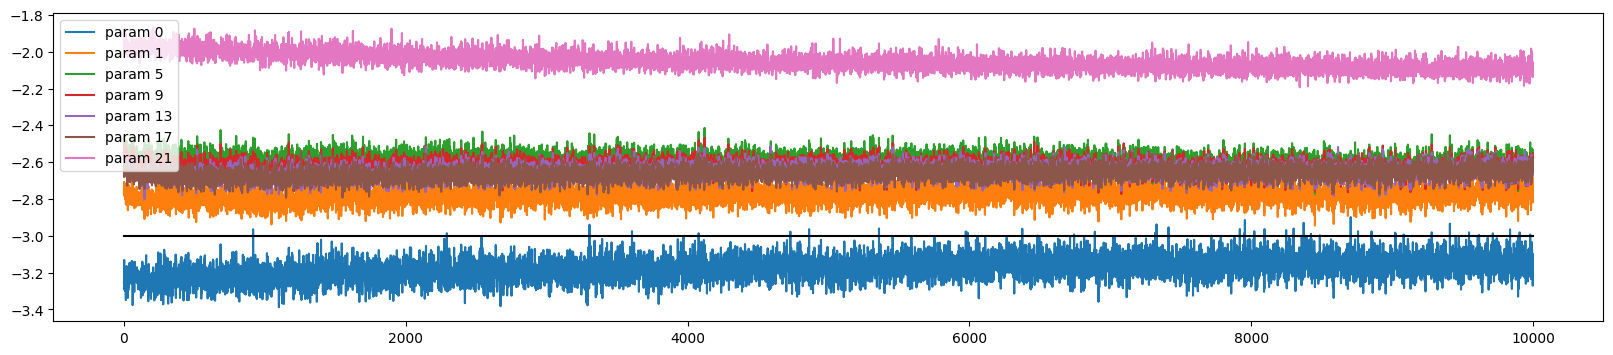

In [892]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [904]:
X = torch.randn(64, 20)
W = torch.randn(20, 30)
W2 = torch.randn(30, 30)

l = X @ (W * 1.666 / 20 ** 0.5)
tanh = l.tanh()
l2 = l @ (W2 * 1.666 / 30 ** 0.5)

{"l mean": l.mean(), "l std": l.std(), "tanh mean": tanh.mean(), "tanh std": tanh.std(), "l2 mean": l2.mean(), "l2 std": l2.std() }

{'l mean': tensor(-0.0114),
 'l std': tensor(1.6666),
 'tanh mean': tensor(0.0062),
 'tanh std': tensor(0.7429),
 'l2 mean': tensor(0.0250),
 'l2 std': tensor(2.7481)}

In [905]:
X = torch.randn(64, 20)
W = torch.randn(20, 30)
W2 = torch.randn(30, 30)

l = X @ (W / 20 ** 0.5)
tanh = l.tanh()
l2 = l @ (W2 / 30 ** 0.5)

{"l mean": l.mean(), "l std": l.std(), "tanh mean": tanh.mean(), "tanh std": tanh.std(), "l2 mean": l2.mean(), "l2 std": l2.std() }

{'l mean': tensor(0.0268),
 'l std': tensor(0.9788),
 'tanh mean': tensor(0.0143),
 'tanh std': tensor(0.6143),
 'l2 mean': tensor(-0.0156),
 'l2 std': tensor(1.0421)}